# **Setting up the environment**

In [1]:
import warnings
warnings.filterwarnings('ignore')

# **Performing PCA with an Undercomplete Linear Autoencoder**

In [2]:
import tensorflow as tf

tf.random.set_seed(42)

encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

In [3]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [4]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 3ms/step


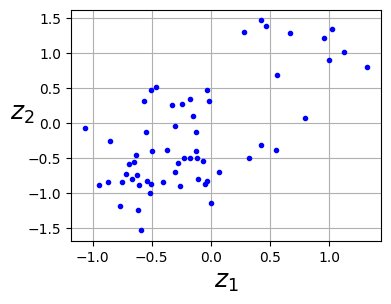

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

# **Stacked Autoencoders**

In [6]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [7]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")                   
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 9s 4ms/step - loss: 0.0235 - val_loss: 0.0183
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0171 - val_loss: 0.0166
Epoch 3/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0160 - val_loss: 0.0158
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0154 - val_loss: 0.0153
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0150 - val_loss: 0.0151
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0148 - val_loss: 0.0148
Epoch 7/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 8/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0144 - val_loss: 0.0146
Epoch 9/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0143 - val_loss: 0.0145
Epoch 10/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.014

1/1 [==============================] - 0s 68ms/step


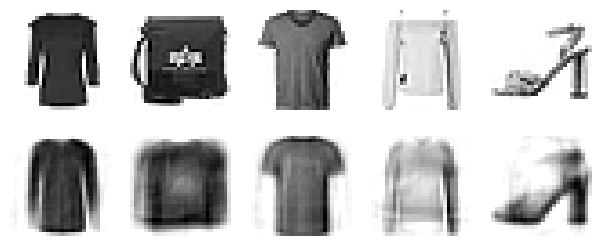

In [8]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

plot_reconstructions(stacked_ae)
plt.show()

In [9]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 1ms/step


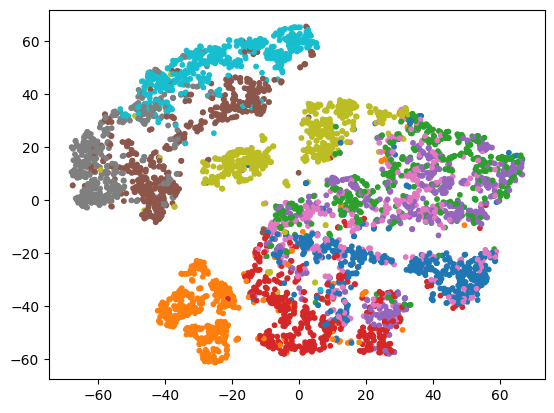

In [10]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

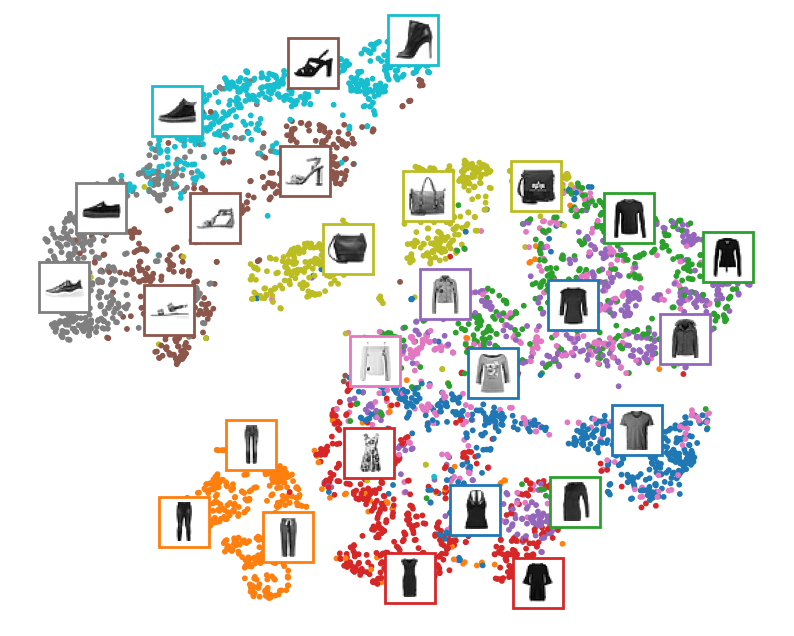

In [11]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

# **Tying weights**

In [12]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=self.dense.input_shape[-1],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [13]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 0.0229 - val_loss: 0.0171
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0148 - val_loss: 0.0145
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0142 - val_loss: 0.0141
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 8/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 9/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 10/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.013

1/1 [==============================] - 0s 68ms/step


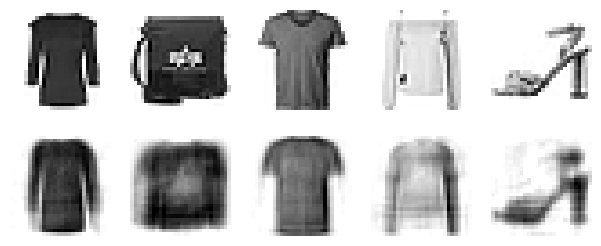

In [14]:
plot_reconstructions(tied_ae)
plt.show()

# **Training one Autoencoder at a Time**

In [15]:
def train_autoencoder(n_neurons, X_train, X_valid, n_epochs=10,
                      output_activation=None):
    n_inputs = X_train.shape[-1]
    encoder = tf.keras.layers.Dense(n_neurons, activation="relu")
    decoder = tf.keras.layers.Dense(n_inputs, activation=output_activation)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss="mse", optimizer="nadam")
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [16]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

X_train_flat = tf.keras.layers.Flatten()(X_train)
X_valid_flat = tf.keras.layers.Flatten()(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, output_activation="relu")

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0184 - val_loss: 0.0115
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0106 - val_loss: 0.0102
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0099 - val_loss: 0.0098
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 8/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0090 - val_loss: 0.0106
Epoch 9/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 10/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.009

In [17]:
stacked_ae_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    enc1, enc2, dec2, dec1,
    tf.keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 94ms/step


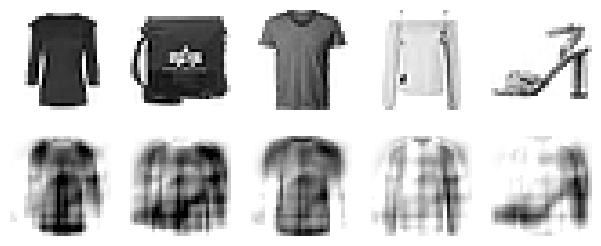

In [18]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

In [19]:
stacked_ae_1_by_1.compile(loss="mse", optimizer="nadam")
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=5,
                                validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 8s 3ms/step - loss: 0.0171 - val_loss: 0.0161
Epoch 2/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0153 - val_loss: 0.0148
Epoch 3/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 4/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 5/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0135 - val_loss: 0.0135


1/1 [==============================] - 0s 67ms/step


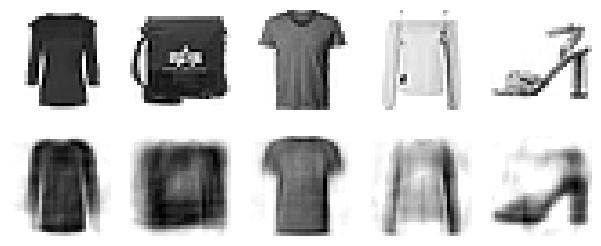

In [20]:
plot_reconstructions(stacked_ae_1_by_1)
plt.show()

# **Convolutional Autoencoders**

In [21]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # output: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # output: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="mse", optimizer="nadam")
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 21s 6ms/step - loss: 0.0302 - val_loss: 0.0215
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0194 - val_loss: 0.0183
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0172 - val_loss: 0.0165
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0160 - val_loss: 0.0156
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0151 - val_loss: 0.0147
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0144 - val_loss: 0.0142
Epoch 7/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0139 - val_loss: 0.0138
Epoch 8/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 9/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0132 - val_loss: 0.0132
Epoch 10/10
1719/1719 [==============================] - 10s 6ms/step - l

1/1 [==============================] - 0s 288ms/step


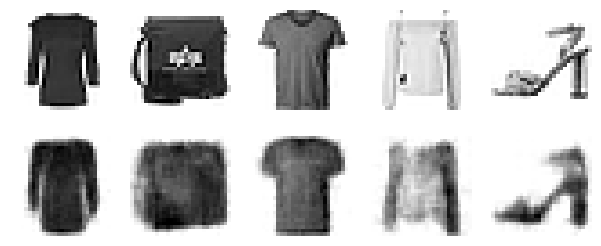

In [22]:
plot_reconstructions(conv_ae)
plt.show()

# **Recurrent Autoencoders**

In [23]:
tf.random.set_seed(42)
tf.keras.backend.clear_session()

recurrent_encoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(30)
])
recurrent_decoder = tf.keras.Sequential([
    tf.keras.layers.RepeatVector(28),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dense(28)
])
recurrent_ae = tf.keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="mse", optimizer="nadam")

In [24]:
history = recurrent_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 26s 10ms/step - loss: 0.0259 - val_loss: 0.0195
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0176 - val_loss: 0.0169
Epoch 3/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0141 - val_loss: 0.0137
Epoch 5/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0125 - val_loss: 0.0122
Epoch 7/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 8/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 9/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0112 - val_loss: 0.0118
Epoch 10/10
1719/1719 [==============================] - 16s 9ms/step - 

1/1 [==============================] - 1s 949ms/step


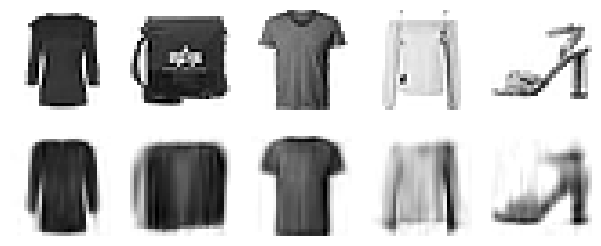

In [25]:
plot_reconstructions(recurrent_ae)
plt.show()